# Imports

In [52]:
import os
import random
from datetime import datetime
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from skimage.feature import hog
import torchvision.utils
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from IPython.display import display, clear_output

GLOBAL_SEED = 1775

%matplotlib inline
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Helper Functions

In [58]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis('off')
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
def show_plot(iteration, loss):
    clear_output(wait=True)
    plt.figure(figsize=(10,8))
    plt.plot(iteration, loss)
    plt.show()

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def worker_init_fn(worker_id):
    random.seed(torch.initial_seed() + worker_id)

# Configuration Class

In [54]:
class Config():
    train_dir = '/data/rgbd_face_data/kinect_cropped/train'
    test_dir = '/data/rgbd_face_data/kinect_cropped/test'
    train_batch_size = 64
    train_number_epochs = 50
    test_batch_size = 1

# Custom Dataset Class

In [55]:
class FaceIdDataset(Dataset):
    
    def __init__(self, imageFolderDataset, transform=None, is_train=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.is_train = is_train
        
    def __getitem__(self, index):
        img0_tuple = self.imageFolderDataset.imgs[index]
        
        img0 = Image.open(img0_tuple[0])
        depth0 = np.load(img0_tuple[0][:-5] + "d.npy")
        rgbd0 = np.dstack((np.asarray(img0), depth0/255))
        hog0 = np.load(img0_tuple[0][:-5] + "h.npy")        
        rgbd0 = np.dstack((rgbd0, hog0))
        if self.transform is not None:
            rgbd0 = self.transform(rgbd0)
            img0 = self.transform(img0)
        
        if not self.is_train:
            return rgbd0.float(), img0_tuple[1]
        
        should_get_same_face = random.randint(0,1)

        if should_get_same_face:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img1 = Image.open(img1_tuple[0])
        depth1 = np.load(img1_tuple[0][:-5] + "d.npy")
        rgbd1 = np.dstack((np.asarray(img1), depth1/255))
        hog1 = np.load(img1_tuple[0][:-5] + "h.npy")
        rgbd1 = np.dstack((rgbd1, hog1))

        if self.transform is not None:
            rgbd1 = self.transform(rgbd1)
            img1 = self.transform(img1)
        
        label = torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        
        return rgbd0.float(), rgbd1.float(), label, img0, img1
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [56]:
train_folders = dset.ImageFolder(root=Config.train_dir)

train_dataset = FaceIdDataset(imageFolderDataset=train_folders,
                              transform=transforms.Compose([transforms.ToTensor()]))

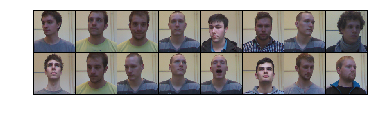

[[1. 0. 1. 0. 1. 1. 1. 1.]]


In [57]:
vis_dataloader = DataLoader(train_dataset,
                            shuffle=True,
                            num_workers=3,
                            batch_size=8,
                            worker_init_fn=worker_init_fn)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

concatenated = torch.cat((example_batch[3],example_batch[4]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape((1,8)))

# Neural Network Architecture

In [34]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(5, 10, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(10),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(10, 20, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(20),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(20, 20, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(20))
        
        self.fc1 = nn.Sequential(
            nn.Linear(20*100*100, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 128))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Contrastive Loss Function

In [35]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output0, output1, label):
        dist = F.pairwise_distance(output0, output1)
        contrastive_loss = torch.mean((1-label) * torch.pow(dist, 2) + 
                                      (label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))
        
        return contrastive_loss

# Train...

In [36]:
train_dataloader = DataLoader(train_dataset, num_workers=6, batch_size=Config.train_batch_size,
                              worker_init_fn=worker_init_fn, sampler=SequentialSampler(train_dataset))

In [37]:
nnet = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(nnet.parameters(), lr = 0.0005)
#writer = SummaryWriter()

In [38]:
counter = []
loss_history = []
iteration = 0

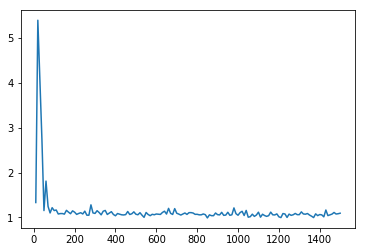

CPU times: user 1min 15s, sys: 1min 29s, total: 2min 45s
Wall time: 1min 56s


In [39]:
%%time
set_seed(GLOBAL_SEED)
for epoch in range(0, Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1, label = data[0:3]
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)
        optimizer.zero_grad()
        output0, output1 = nnet(img0, img1)
        contrastive_loss = criterion(output0, output1, label)
        contrastive_loss.backward()
        optimizer.step()
        if i % 10 == 0:
            iteration += 10
#            writer.add_scalar('data/train_loss', contrastive_loss.item(), iteration)
            counter.append(iteration)
            loss_history.append(contrastive_loss.item())
            show_plot(counter, loss_history)

torch.save(nnet.state_dict(), '/home/astewart/repos/faceid/models/siamese_50epochs.pt')

In [128]:
#nnet = SiameseNetwork().cuda()
#nnet.load_state_dict(torch.load('/home/astewart/repos/faceid/models/siamese.pt'))

# Testing

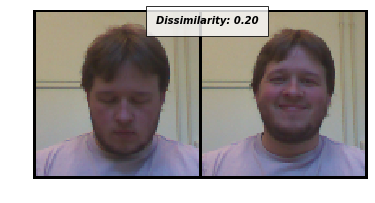

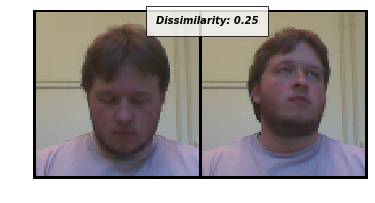

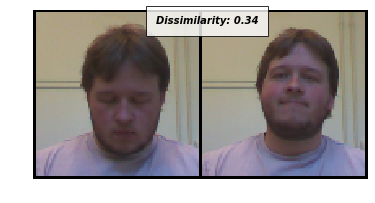

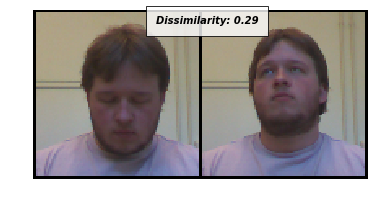

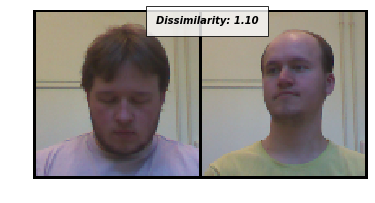

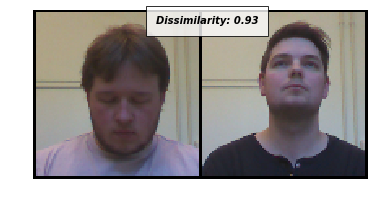

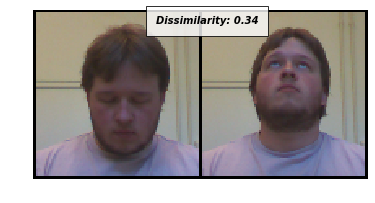

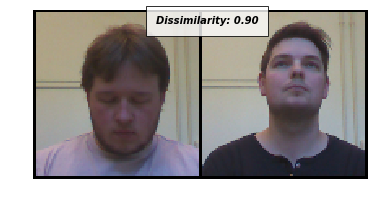

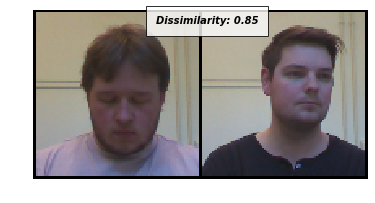

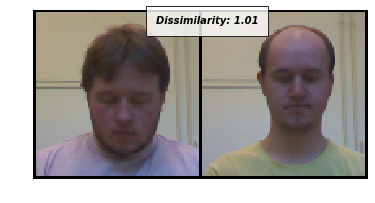

In [40]:
nnet.eval()
test_folders = dset.ImageFolder(root=Config.test_dir)
test_dataset = FaceIdDataset(imageFolderDataset=test_folders,
                               transform=transforms.Compose([transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=1, shuffle=True, worker_init_fn=worker_init_fn)
dataiter = iter(test_dataloader)
rgbd0, _ ,_ , img0, _ = next(dataiter)

for i in range(10):
    _, rgbd1, _, _, img1 = next(dataiter)
    concatenated = torch.cat((img0, img1), 0)
    output0, output1 = nnet(Variable(rgbd0).to(device), Variable(rgbd1).to(device))
    l2_norm = F.pairwise_distance(output0, output1)
    imshow(torchvision.utils.make_grid(concatenated), 'Dissimilarity: {:.2f}'.format(l2_norm.item()))

# Threshold
---

In [41]:
def evaluate_model(model, config, seed=None):
    if seed:
        set_seed(seed)

    test_folders = dset.ImageFolder(root=config.test_dir)
    
    test_dataset = FaceIdDataset(imageFolderDataset=test_folders, is_train=False,
                                   transform=transforms.Compose([transforms.ToTensor()]))
    
    test_loader0 = DataLoader(test_dataset, num_workers=0, batch_size=config.test_batch_size,
                                 worker_init_fn=worker_init_fn, sampler=SequentialSampler(test_dataset))
    
    test_loader1 = DataLoader(test_dataset, num_workers=0, batch_size=config.test_batch_size,
                              worker_init_fn=worker_init_fn, sampler=SequentialSampler(test_dataset))

    dataiter0 = iter(test_loader0)
    dataiter1 = iter(test_loader1)

    sensitivity = []
    specificity = []
    f1 = []
    accuracy = []
    y_true = np.array([])
    distances = np.array([])

    nnet.eval()
    with torch.no_grad():
        for x0, id0  in dataiter0:
            for x1, id1 in dataiter1:
                label = int(id0!=id1)
                y_true = np.append(y_true, label)
                output0, output1 = nnet(x0.to(device), x1.to(device))
                dist = F.pairwise_distance(output0, output1)
                distances = np.append(distances, dist.item())

    thresholds = np.linspace(distances.min(),distances.max(),201)
    for thresh in thresholds:
        y_pred = (distances > thresh).astype(float)
        sensitivity.append(precision_score(y_true, y_pred, pos_label=0))
        specificity.append(recall_score(y_true, y_pred, pos_label=1))
        f1.append(f1_score(y_true, y_pred, pos_label=0))
        accuracy.append(accuracy_score(y_true, y_pred))
    
    return {"thresholds":thresholds, 
            "sensitivity":sensitivity, 
            "specificity":specificity,
            "f1":f1, 
            "accuracy":accuracy}

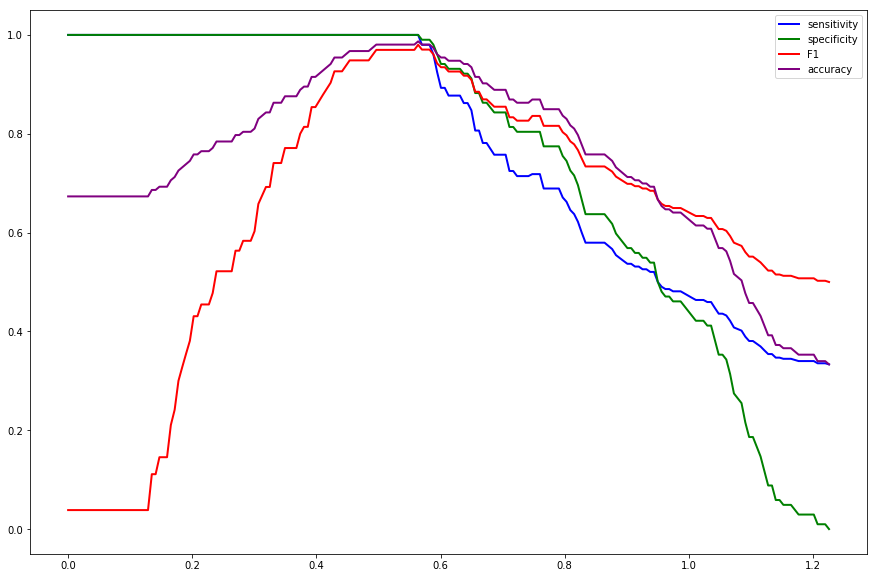

In [49]:
results = evaluate_model(nnet, Config)
plt.figure(figsize=(15,10))
plt.plot(results['thresholds'], results['sensitivity'], marker='', color='blue', linewidth=2, label='sensitivity')
plt.plot(results['thresholds'], results['specificity'], marker='', color='green', linewidth=2, label='specificity')
plt.plot(results['thresholds'], results['f1'], marker='', color='red', linewidth=2, label='F1')
plt.plot(results['thresholds'], results['accuracy'], marker='', color='purple', linewidth=2, label='accuracy')
plt.legend()

In [43]:
spec = np.array(results['specificity'])
idx = np.argwhere(spec == 1)[-1,:].item()

In [44]:
print("Threshold: {:.3f}\nSensitivity: {:.3f}\nSpecificity: {:.3f}\nAccuracy: {:.3f}".format(results['thresholds'][idx],
                                                                                             results['sensitivity'][idx],
                                                                                             results['specificity'][idx],
                                                                                             results['accuracy'][idx]))

Threshold: 0.564
Sensitivity: 1.000
Specificity: 1.000
Accuracy: 0.987


In [12]:
%%time

for number_epochs in [50]*10:
    set_seed(GLOBAL_SEED)
    learn_rate = 0.0005
    nnet = SiameseNetwork().to(device)
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(nnet.parameters(), lr = learn_rate)
    counter = []
    loss_history = []
    iteration = 0
    start = datetime.now()
    
    for epoch in range(0, number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1, label = data[0:3]
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            optimizer.zero_grad()
            output0, output1 = nnet(img0, img1)
            contrastive_loss = criterion(output0, output1, label)
            contrastive_loss.backward()
            optimizer.step()
            if i % 10 == 0:
                iteration += 10
                counter.append(iteration)
                loss_history.append(contrastive_loss.item())
                #show_plot(counter, loss_history)
    
    results = evaluate_model(nnet, Config, seed=GLOBAL_SEED)
    
    spec = np.array(results['specificity'])
    idx = np.argwhere(spec == 1)[-1,:].item()
    run = {
    'runtime': start,    
    'epochs': number_epochs,
    'learn_rate': learn_rate,
    'threshold': results['thresholds'][idx],
    'sensitivity': results['sensitivity'][idx],
    'specificity': results['specificity'][idx],
    'F1': results['f1'][idx],
    'accuracy': results['accuracy'][idx]
    }

    if os.path.isfile('/home/astewart/repos/faceid/results/results.csv'):
        df = pd.read_csv('/home/astewart/repos/faceid/results/results.csv')
        df = df.append(run, ignore_index=True)
    else:
        os.makedirs('/home/astewart/repos/faceid/results', exist_ok=True)
        df = pd.DataFrame(run, index=[0])
    df.to_csv('/home/astewart/repos/faceid/results/results.csv', index=False)
    clear_output(wait=True)
    display(df)

,F1,accuracy,epochs,learn_rate,runtime,sensitivity,specificity,threshold
0,0.990099,0.993464,50,0.0005,2018-11-04 21:02:36.696929,1.0,1.0,0.740824
1,1.000000,1.000000,75,0.0005,2018-11-04 21:04:28.545837,1.0,1.0,0.798394
2,0.948454,0.967320,100,0.0005,2018-11-04 21:07:15.184833,1.0,1.0,0.641185
3,0.990099,0.993464,125,0.0005,2018-11-04 21:10:56.649139,1.0,1.0,0.892497
4,0.800000,0.888889,150,0.0005,2018-11-04 21:15:32.614746,1.0,1.0,0.368476
5,0.866667,0.921569,175,0.0005,2018-11-04 21:21:03.625573,1.0,1.0,0.365143
6,0.937500,0.960784,200,0.0005,2018-11-04 21:27:30.111010,1.0,1.0,0.406578
7,1.000000,1.000000,50,0.0005,2018-11-04 21:38:07.626985,1.0,1.0,0.714953
8,0.969697,0.980392,50,0.0005,2018-11-04 21:39:59.930628,1.0,1.0,0.748825
9,0.990099,0.993464,50,0.0005,2018-11-04 21:41:51.920553,1.0,1.0,0.608582


CPU times: user 9min 21s, sys: 7min 56s, total: 17min 17s
Wall time: 18min 43s


In [ ]:
df = pd.read_csv('/home/astewart/repos/faceid/results/results.csv')
display(df)